In [1]:
from Bio.PDB.MMCIFParser import MMCIFParser
from Bio.PDB.Residue import Residue
from itertools import product
from typing import List
import numpy as np
from pathlib import Path
from Bio.PDB.PDBParser import PDBParser
from Bio.SeqUtils import seq1
import pandas as pd
from Bio import SeqIO

species = ['human', 'worm', 'yeast', 'zebrafish']
pdb_file_path = Path("~/database/pdb/species").expanduser()
fasta_file_path = Path("~/database/uniprot/fasta/").expanduser()

## analyze distance distributuion

### 1. collect data: min distance in all predicted residues

In [2]:
hetero_atoms = {'N', 'O', 'S'}
main_chain_atom_names = {'CA', 'O', 'N', 'C', 'OXT'}

def calc_min_distance(
    resi1: Residue,
    residues: List[Residue],
):
    def calc_distance(r1: Residue, r2: Residue):
        atoms_1 = [a for a in r1.get_atoms() if a.element in hetero_atoms and a.get_name() not in main_chain_atom_names] # side chain hetero atoms
        atoms_2 = [a for a in r2.get_atoms() if a.element in hetero_atoms and a.get_name() not in main_chain_atom_names]
        distances = [i - j for i, j in product(atoms_1, atoms_2)]
        return np.min(distances) if len(distances) != 0 else np.inf
    
    residues_ = [r for r in residues if r != resi1]
    distances = [calc_distance(resi1, r) for r in residues_]
    index = np.argmin(distances)
    
    min_distance = distances[index]
    
    return min_distance

#### 1.1 collect predicted results from af2 struct

In [3]:
uniprots_to_seq = dict()
for i in species:
    fasta_file = fasta_file_path / f"{i}_for_msa.fasta"
    for s in SeqIO.parse(fasta_file, "fasta"):
        uniprots_to_seq[s.id] = str(s.seq)

In [4]:
import sys
sys.path.append(f"{PROJECT_DIR}/dataset/collect/scripts/utils/")
from mmcif_utils import align_two_seq

df_high_conf = pd.read_table("./no_evidence_pred_mbps.tsv")
af2_distances = []
adjacent_pairs = []
for sp_uniprot, df in df_high_conf.groupby(by=['species', 'seq_id']):
    species, uniprot = sp_uniprot
    pdb_file = pdb_file_path / f"{species}_af2" / f"AF-{uniprot}-F1-model_v4.pdb"
    
    if not pdb_file.exists(): continue
    
    residues = list(PDBParser(QUIET=True).get_structure(uniprot, pdb_file).get_residues())
    seq_af2 = ""
    for r in residues:
        seq_af2 += seq1(r.get_resname())
    seq_uniprot = uniprots_to_seq[uniprot]
    uni_to_af2 = align_two_seq(seq_uniprot, seq_af2) # may not consistent, such as P51606
    
    target_af2_seq_posis = set()    
    for _, row in df.iterrows():
        resi_name_1 = row['resi_1']
        resi_name_2 = row['resi_2']
        posi_1 = row['resi_seq_posi_1']
        posi_2 = row['resi_seq_posi_2']
        
        try:
            posi_1_af2 = uni_to_af2[posi_1]
            posi_2_af2 = uni_to_af2[posi_2]
            resi_1: Residue = residues[posi_1_af2]
            resi_2: Residue = residues[posi_2_af2]
            assert seq1(resi_1.get_resname()) == resi_name_1
            assert seq1(resi_2.get_resname()) == resi_name_2
            
            target_af2_seq_posis.add(posi_1_af2)
            target_af2_seq_posis.add(posi_2_af2)
        except:
            continue
    
    target_residues = set()
    for index, r in enumerate(residues):
        if index in target_af2_seq_posis: target_residues.add(r)
    
    for r in target_residues:
        distance = calc_min_distance(r, target_residues)
        if distance < 2.5:
            adjacent_pairs.append((distance, r.get_full_id(), r.get_resname()))
        af2_distances.append(distance)

In [5]:
adjacent_pairs[:10]

[(2.0469828, ('A0A1B0GTK4', 0, 'A', (' ', 105, ' ')), 'CYS'),
 (2.0469828, ('A0A1B0GTK4', 0, 'A', (' ', 49, ' ')), 'CYS'),
 (2.0623527, ('A0A494C0Y3', 0, 'A', (' ', 96, ' ')), 'CYS'),
 (2.0623527, ('A0A494C0Y3', 0, 'A', (' ', 99, ' ')), 'CYS'),
 (2.0790782, ('A0A6Q8PFD8', 0, 'A', (' ', 29, ' ')), 'CYS'),
 (2.032774, ('A0A6Q8PFD8', 0, 'A', (' ', 32, ' ')), 'CYS'),
 (2.032774, ('A0A6Q8PFD8', 0, 'A', (' ', 14, ' ')), 'CYS'),
 (2.0790782, ('A0A6Q8PFD8', 0, 'A', (' ', 17, ' ')), 'CYS'),
 (2.0284405, ('A1L188', 0, 'A', (' ', 61, ' ')), 'CYS'),
 (2.037651, ('A1L188', 0, 'A', (' ', 35, ' ')), 'CYS')]

#### 1.2 compare with true distribution in metalnet dataset

In [6]:
df_pdb_files = pd.read_table("~/database/pdb/rcsb_20230430/all_protein_files.csv")
dict_pdb_files = dict(zip(df_pdb_files['pdb'], df_pdb_files['pdb_file']))

resi_id_to_full_id = dict()
df = pd.read_table(f"{PROJECT_DIR}/dataset/collect/nr_metal_sites.tsv")
for _, row in df.iterrows():
    pdb, model, chain = row['pdb'], row['model'], row['resi_chain']
    resi_pdb_seq_num, resi_ndb_seq_can_num = row['resi_pdb_seq_num'], row['resi_ndb_seq_can_num']
    ins_code = row['resi_pdb_ins_code']
    short_id = (pdb, chain, resi_ndb_seq_can_num)
    full_id = (pdb, model, chain, (" ", resi_pdb_seq_num, ins_code))
    resi_id_to_full_id[short_id] = full_id

In [7]:
# pair distance distribution in a single chain
df_test = pd.read_table(f"{PROJECT_DIR}/dataset/transform/train_metalnet.tsv")
df_train = pd.read_table(f"{PROJECT_DIR}/dataset/transform/test_metalnet.tsv")
df_all = pd.concat([df_test, df_train])

distance_threshold = 2
residues_with_low_min_distance = []
rcsb_distances = []
for pdb, df in df_all.groupby(['pdb']):
    pdb_file = dict_pdb_files[pdb]
    pdb_file = Path(pdb_file).expanduser()
    
    resi_ids = set(zip(df['pdb'], df['resi_chain'], df['resi_ndb_seq_can_num']))
    resi_ids = set([resi_id_to_full_id[i] for i in resi_ids])
    residues = MMCIFParser(QUIET=True).get_structure(pdb, pdb_file).get_residues()

    target_residues = set()
    for r in residues:
        if r.get_full_id() in resi_ids: target_residues.add(r)
    
    if len(target_residues) == 1: continue
    for r in target_residues:
        min_distance = calc_min_distance(r, target_residues)
        if min_distance < distance_threshold:
            residues_with_low_min_distance.append((r.get_full_id(), min_distance))
        rcsb_distances.append(min_distance)

# about half an hour

In [8]:
# some weird cases
residues_with_low_min_distance.sort(key=lambda x: x[1])
residues_with_low_min_distance[:10]

[(('1ile', 0, 'A', (' ', 502, ' ')), 0.92674744),
 (('1ile', 0, 'A', (' ', 504, ' ')), 0.92674744),
 (('1ile', 0, 'A', (' ', 464, ' ')), 0.9428607),
 (('1ile', 0, 'A', (' ', 461, ' ')), 0.9428607),
 (('1ile', 0, 'A', (' ', 392, ' ')), 1.0615674),
 (('1ile', 0, 'A', (' ', 389, ' ')), 1.0615674),
 (('1ile', 0, 'A', (' ', 181, ' ')), 1.3816304),
 (('1ile', 0, 'A', (' ', 184, ' ')), 1.6612158),
 (('6agi', 0, 'B', (' ', 485, ' ')), 1.7248284),
 (('6agi', 0, 'B', (' ', 483, ' ')), 1.7248284)]

In [9]:
# skip distances higher than 10
distance_threshold = 10
af2 = np.array(af2_distances)
af2 = af2[np.where(af2 <= distance_threshold)]
print(len(af2) / len(af2_distances)) # how many are discarded by threshold
pdb = np.array(rcsb_distances)
pdb = pdb[np.where(pdb <= distance_threshold)]
print(len(pdb) / len(rcsb_distances))

0.9671975412126292
0.9859970785271748


### 2 visualize

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use(f"{PROJECT_DIR}/asset/metalnet.mplstyle")

<Axes: ylabel='Density'>

<Axes: ylabel='Density'>

Text(0, 0.5, 'Density')

Text(0.5, 0, 'Minimum pair distance (Å)')

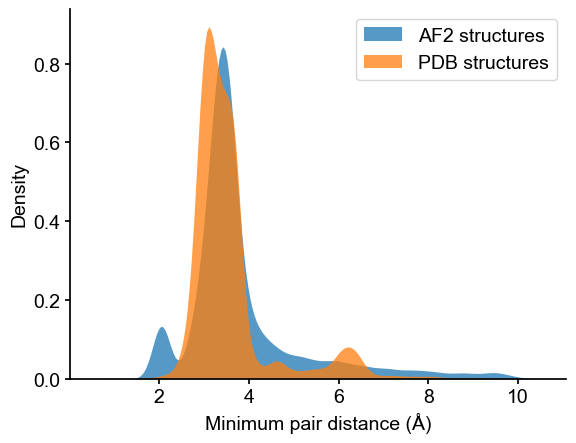

In [12]:
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

sns.kdeplot(af2, linewidth=0, multiple="stack")
sns.kdeplot(pdb, linewidth=0, multiple="stack")
plt.ylabel("Density")
plt.xlabel("Minimum pair distance (Å)")
plt.legend(labels=['AF2 structures',
                   'PDB structures'],
           loc='upper right',
           bbox_to_anchor=(1,1))

plt.savefig("./fig/distribution_pair_distance.pdf", bbox_inches="tight", transparent=True)